In [1]:
import jax.numpy as jnp 
from jax import vmap, jit
import matplotlib.pyplot as plt 

try:
    from lqrax import iLQR
except:
    %pip install lqrax
    from lqrax import iLQR

In [2]:
class DroneLandingILQR(iLQR):
    def __init__(self, dt, x_dim, u_dim, Q, R):
        super().__init__(dt, x_dim, u_dim, Q, R)
    
    def dyn(self, xt, ut):
        x, y, vx, vy, theta, omega = xt
        T, tau = ut
        m = 1.0
        I = 5.0
        g = 9.81
        dx = vx
        dy = vy
        dvx = -(T / m) * jnp.sin(theta)
        dvy = (T / m) * jnp.cos(theta) - g
        dtheta = omega
        domega = tau / I
        return jnp.array([dx, dy, dvx, dvy, dtheta, domega])
    
    def loss(self, xt, ut):
        target = jnp.zeros(6)
        state_error = xt - target
        return jnp.sum(state_error**2) + 0.01 * jnp.sum(ut**2)

iter[  0] - loss: 2328.2400 | step_size: 0.0530
iter[ 10] - loss:   77.3508 | step_size: 0.0108
iter[ 20] - loss:   61.2380 | step_size: 0.0174
iter[ 30] - loss:   61.1950 | step_size: 0.0174
iter[ 40] - loss:   61.1939 | step_size: 0.0149
iter[ 50] - loss:   61.1939 | step_size: 0.0042
iter[ 60] - loss:   61.1939 | step_size: 0.0621
iter[ 70] - loss:   61.1939 | step_size: 0.0010
iter[ 80] - loss:   61.1939 | step_size: 0.0010
iter[ 90] - loss:   61.1939 | step_size: 0.0010
iter[100] - loss:   61.1939 | step_size: 0.0010


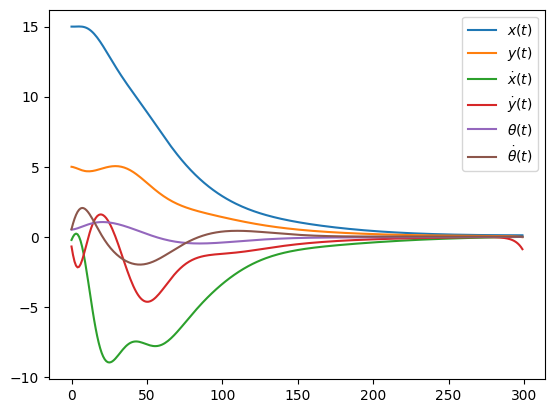

In [3]:
Q = jnp.diag(jnp.array([100.0, 100.0, 10.0, 10.0, 1000.0, 100.0])) * 0.001
R = jnp.diag(jnp.array([1.0, 1.0])) * 0.001
drone_ilqr = DroneLandingILQR(dt=0.02, x_dim=6, u_dim=2, Q=Q, R=R)


@jit 
def loss_func(x_traj, u_traj):
    return vmap(drone_ilqr.loss, in_axes=(0,0))(x_traj, u_traj).mean()

@jit 
def line_search(x0, u_traj, v_traj, step_sizes):
    u_traj_batch = u_traj[None, :, :] + step_sizes[:, None, None] * v_traj[None, :, :]
    x_traj_batch = vmap(drone_ilqr.dyn_scan, in_axes=(None,0))(x0, u_traj_batch)
    costs = vmap(loss_func, in_axes=(0,0))(x_traj_batch, u_traj_batch)
    return step_sizes[jnp.argmin(costs)]


x0 = jnp.array([15.0, 5.0, -0.5, 0.0, 0.5, 0.1])
tsteps = 300
tlist = jnp.arange(tsteps)
u_traj = jnp.zeros((tsteps, 2))
x_traj = drone_ilqr.dyn_scan(x0, u_traj)

num_iters = 100
step_sizes = jnp.power(10.0, jnp.linspace(-3.0, -1.0, 30))
for iter in range(num_iters+1):
    A_traj, B_traj = drone_ilqr.linearize_dyn(x0, u_traj)
    a_traj, b_traj = drone_ilqr.linearize_loss(x0, u_traj)
    v_traj = drone_ilqr.solve(A_traj, B_traj, a_traj, b_traj)
    step_size = line_search(x0, u_traj, v_traj, step_sizes)
    u_traj += step_size * v_traj
    if iter % 10 == 0:
        x_traj = drone_ilqr.dyn_scan(x0, u_traj)
        loss = loss_func(x_traj, u_traj)
        print(f'iter[{iter:3d}] - loss: {loss:9.4f} | step_size: {step_size:.4f}')

opt_x_traj = drone_ilqr.dyn_scan(x0, u_traj)
plt.plot(opt_x_traj[:,0], label=r'$x(t)$')
plt.plot(opt_x_traj[:,1], label=r'$y(t)$')
plt.plot(opt_x_traj[:,2], label=r'$\dot{x}(t)$')
plt.plot(opt_x_traj[:,3], label=r'$\dot{y}(t)$')
plt.plot(opt_x_traj[:,4], label=r'$\theta(t)$')
plt.plot(opt_x_traj[:,5], label=r'$\dot{\theta}(t)$')
plt.legend()
plt.show()
plt.close()

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

def animate_drone_trajectory(states, controls):
    # Constants for drawing and scaling
    drone_length = 1.0       # Used for drawing the orientation arrow (e.g., how far forward to show)
    prop_offset = 0.8        # Distance from the center to each propeller (used as 'd')
    fire_scale = 0.10        # Scaling factor for converting thrust magnitude to arrow length
    max_arrow_len = 1.0      # Cap on arrow length for display purposes
    margin = 2.0
    
    # Determine plot limits from the state data.
    xmin, xmax = states[:,0].min()-margin, states[:,0].max()+margin
    ymin, ymax = states[:,1].min()-margin*0.5, states[:,1].max()+margin*1.5
    xscale = (xmax - xmin) / (ymax - ymin)
    
    # Create the figure and axis.
    fig, ax = plt.subplots(figsize=(4.0*xscale, 4.0), dpi=100, tight_layout=True)
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_aspect('equal')
    ax.plot(0.0, 0.0, marker='x', markersize=15, color='b')  # origin marker for reference

    # Create plot elements:
    # - drone_body_line: line between left and right motor positions (drone "body")
    # - orientation_line: arrow indicating forward direction
    # - left_motor_marker & right_motor_marker: markers for the motor positions
    # - left_thrust_line & right_thrust_line: arrows for individual motor thrusts
    drone_body_line, = ax.plot([], [], 'k-', lw=2)
    orientation_line, = ax.plot([], [], 'k-', lw=2)
    left_motor_marker, = ax.plot([], [], 'ko', markersize=8)
    right_motor_marker, = ax.plot([], [], 'ko', markersize=8)
    left_thrust_line, = ax.plot([], [], color='orange', lw=3)
    right_thrust_line, = ax.plot([], [], color='green', lw=3)

    def init():
        drone_body_line.set_data([], [])
        orientation_line.set_data([], [])
        left_motor_marker.set_data([], [])
        right_motor_marker.set_data([], [])
        left_thrust_line.set_data([], [])
        right_thrust_line.set_data([], [])
        return (drone_body_line, orientation_line, 
                left_motor_marker, right_motor_marker, 
                left_thrust_line, right_thrust_line)

    def update(i):
        # Unpack state and control at time step i.
        state = states[i]
        control = controls[i]
        x, y, vx, vy, theta, omega = state
        T, tau = control
        center = np.array([x, y])
        
        # Determine drone orientation: 
        # body_dir is the "forward" direction; when theta=0, body_dir = (0, 1) (upward).
        body_dir = np.array([-np.sin(theta), np.cos(theta)])
        # Perpendicular to body_dir (points to the left for theta=0).
        perp = np.array([-np.cos(theta), -np.sin(theta)])
        
        # Compute positions of the left and right motors.
        left_motor = center + prop_offset * perp
        right_motor = center - prop_offset * perp

        # Update the drone body: a line connecting left and right motors.
        drone_body_line.set_data([left_motor[0], right_motor[0]],
                                  [left_motor[1], right_motor[1]])
        # Orientation arrow: drawn from the center forward along body_dir.
        orientation_end = center + (drone_length/2) * body_dir
        orientation_line.set_data([center[0], orientation_end[0]],
                                  [center[1], orientation_end[1]])
        
        # Update motor markers.
        left_motor_marker.set_data([left_motor[0]], [left_motor[1]])
        right_motor_marker.set_data([right_motor[0]], [right_motor[1]])
        
        # Compute individual motor thrusts:
        # T_total = T = T_left + T_right
        # tau = prop_offset * (T_left - T_right)
        T_left = 0.5 * (T + tau / prop_offset)
        T_right = 0.5 * (T - tau / prop_offset)
        
        # For the left motor, draw an arrow starting at left_motor.
        left_dir = body_dir if T_left >= 0 else -body_dir
        left_thrust_length = np.minimum(fire_scale * abs(T_left), max_arrow_len)
        left_thrust_end = left_motor - left_thrust_length * left_dir
        left_thrust_line.set_data([left_motor[0], left_thrust_end[0]],
                                   [left_motor[1], left_thrust_end[1]])
        
        # For the right motor, draw an arrow starting at right_motor.
        right_dir = body_dir if T_right >= 0 else -body_dir
        right_thrust_length = np.minimum(fire_scale * abs(T_right), max_arrow_len)
        right_thrust_end = right_motor - right_thrust_length * right_dir
        right_thrust_line.set_data([right_motor[0], right_thrust_end[0]],
                                    [right_motor[1], right_thrust_end[1]])
        
        return (drone_body_line, orientation_line, 
                left_motor_marker, right_motor_marker, 
                left_thrust_line, right_thrust_line)

    ani = animation.FuncAnimation(fig, update, frames=len(states), 
                                  init_func=init, interval=20, blit=True)
    video = HTML(ani.to_html5_video())
    plt.close(fig)
    return video

animate_drone_trajectory(opt_x_traj, u_traj)